### Imports

In [15]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [16]:
pip install faiss-gpu --quiet

In [17]:
import pandas as pd
from datasets import load_dataset
import faiss
from sentence_transformers import SentenceTransformer

### Dataset

In [ ]:
dataset = load_dataset("scientific_papers", "arxiv")
df = pd.DataFrame(dataset['train'])
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.27k [00:00<?, ?B/s]

scientific_papers.py:   0%|          | 0.00/5.35k [00:00<?, ?B/s]

The repository for scientific_papers contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scientific_papers.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

,article,abstract,section_names
0,additive models @xcite provide an important fa...,additive models play an important role in sem...,introduction\nmain results on learning rates\n...
1,the leptonic decays of a charged pseudoscalar ...,"we have studied the leptonic decay @xmath0 , ...",[sec:introduction]introduction\n[sec:detector]...
2,the transport properties of nonlinear non - eq...,"in 84 , 258 ( 2000 ) , mateos conjectured tha...",introduction\nregularity and chaos in single-p...
3,studies of laser beams propagating through tur...,the effect of a random phase diffuser on fluc...,introduction\nthe method of photon distributio...
4,the so - called `` nucleon spin crisis '' rais...,with a special intention of clarifying the un...,introduction\nmodel lagrangian with pion mass ...


### EDA

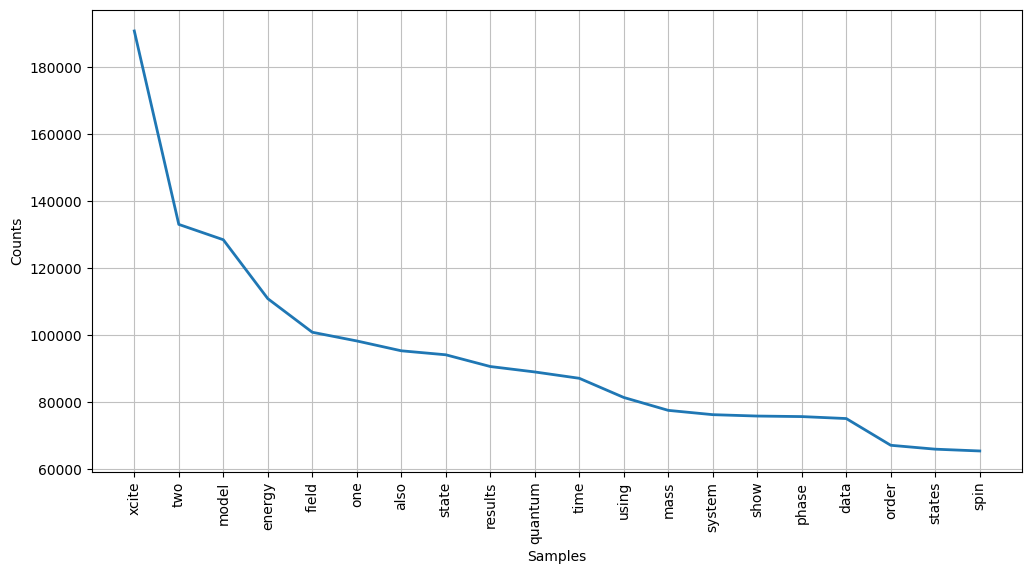

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
from nltk.probability import FreqDist

stop_words = set(stopwords.words('english'))

# Tokenize and remove stopwords from 'abstract'
tokens = [word.lower() for abstract in df['abstract'] for word in word_tokenize(str(abstract)) if word.isalpha()]
filtered_tokens = [word for word in tokens if word not in stop_words]

# Calculate frequency distribution
fdist = FreqDist(filtered_tokens)
top_words = fdist.most_common(20)

# Plot word frequency distribution
plt.figure(figsize=(12, 6))
fdist.plot(20, cumulative=False)

### Preprocessing

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer  = WordNetLemmatizer()


def preprocess_text(text):
  if not isinstance(text, str):
    return ""

  text = text.lower()
  text = re.sub(r'[^a-z0-9\s]', '', text)
  words = text.split()
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
  return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Embedding Generation

In [20]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')


def create_faiss_index(documents, encoder_model):
  # Encode the documents into vectors
  document_vectors = encoder_model.encode(documents)

  # Create a FAISS index and add the vectors
  dimension = document_vectors.shape[1]  # Dimensionality of the embeddings
  faiss_index = faiss.IndexFlatL2(dimension)  # L2 distance (Euclidean distance)
  faiss_index.add(document_vectors)

  return faiss_index, documents


def retrieve_documents(query, faiss_index, documents, encoder_model, top_k=3):
  # Encode the query into a vector
  query_vector = encoder_model.encode([query])

  # Search the FAISS index for the top-k nearest neighbors
  _, indices = faiss_index.search(query_vector, top_k)

  # Retrieve the corresponding documents
  retrieved_docs = [documents[idx] for idx in indices[0]]

  return retrieved_docs

In [5]:
# import numpy as np

# def generate_embeddings(embedding_model, data):
#   embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
#   embeddings = embedding_model.encode(data, batch_size=64, device='cuda')
#   embeddings = np.array(embeddings)
#   dimension = embeddings.shape[1]
#   index = faiss.IndexFlatL2(dimension)
#   index.add(embeddings)
#   return embeddings


In [6]:
# def get_context(query, embedding_model, faiss_index, top_k=5):
#   metadata = df['article'].to_dict()
#   query_embedding = embedding_model.encode([query])
#   distances, indices = faiss_index.search(query_embedding, top_k)

#   # Retrieve metadata for the top-k results
#   result = []
#   for idx in indices[0]:
#       result.append(metadata[idx])
#   final_text = "\n".join(result)
#   final_text = preprocess_text(final_text)
#   return final_text

### Initiallizing the Model

In [21]:
from huggingface_hub import login
login()

In [22]:
try:
  # if the code block ran before, this will be executed
  print(type(model))
except:
  # this is the first time, so we will go ahead and create the model
  !pip install accelerate bitsandbytes --quiet
  !pip install --upgrade transformers --quiet

  import torch
  from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
  from accelerate import infer_auto_device_map, init_empty_weights

  model_name = "mistralai/Mistral-7B-Instruct-v0.3"
  config = AutoConfig.from_pretrained(model_name)

  # load model tokenizer
  tokenizer = AutoTokenizer.from_pretrained(
      model_name,
      trust_remote_code = True,
  )

  with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)

  # For effective GPU usuage
  device_map = infer_auto_device_map(model, max_memory={0: "20GiB", "cpu": "20GiB", "disk": "0GiB"})

  # load model
  model = AutoModelForCausalLM.from_pretrained(
      model_name,
      trust_remote_code = True,
      device_map = device_map,
  )
  model.eval()

<class 'transformers.models.mistral.modeling_mistral.MistralForCausalLM'>


### Creating the RAG System

In [ ]:
def get_relevant_documents_for_question(question, faiss_index, documents, encoder_model, top_k=3):
  encoded_question = encoder_model.encode([question])
  return retrieve_documents(question, faiss_index, documents, encoder_model, top_k)


def get_answers_from_llm(question, tokenizer, model, paragraphs):
  prompt = f"""
    Answer the following question by using the extracted paragraphs for additional details. End the text after your response. Do not generate any other text after that.

    Paragraphs:

    {paragraphs}

    Question: {question}
    Answer:
  """
  token_ids = tokenizer.encode(prompt, add_special_tokens=False ,return_tensors="pt")
  output_ids = model.generate(
        token_ids.to(model.device),
        max_new_tokens=200,
      )

  output = tokenizer.decode(output_ids[0][token_ids.size(1) :])
  return output


def rag_system(question, faiss_index, documents, encoder_model, tokenizer, model, top_k=3):
  relevant_documents = get_relevant_documents_for_question(question, faiss_index, documents, encoder_model, top_k=top_k)
  answer = get_answers_from_llm(question, tokenizer, model, relevant_documents)
  return answer

In [12]:
# from unsloth import FastLanguageModel
from datasets import Dataset
import torch

# Load the dataset from CSV
dataset = Dataset.from_csv("/content/Query_response_with_specific_questions.csv")
column_names = ['Unnamed: 0', 'article', 'abstract', 'section_names', 'query', 'response']
def preprocess_function(examples):
    inputs = [
        f"### Context:\n{context}\n\n### Query:\n{query}\n\n### Response:\n{response}"
        for context, query, response in zip(examples["article"], examples["query"], examples["response"])
    ]
    tokenized = tokenizer(inputs, truncation=True, padding="max_length", max_length=512)

    # Add labels and fix out-of-range values
    labels = tokenized["input_ids"].copy()
    vocab_size = tokenizer.vocab_size
    for i, label_sequence in enumerate(labels):
        labels[i] = [l if l < vocab_size else -100 for l in label_sequence]
    tokenized["labels"] = labels

    return tokenized
tokenized_datasets = dataset.map(preprocess_function, batched=True ,remove_columns= column_names)

train_test_split = tokenized_datasets.train_test_split(test_size=0.2)

train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = "unsloth/mistral-7b-v0.3", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
#     max_seq_length = 2048,
#     dtype = None,
#     load_in_4bit = True,
# )

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

In [14]:
# from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
# from peft import LoraConfig, get_peft_model
# from datasets import load_dataset

# # Load the model and tokenizer
# model_name = "mistralai/Mistral-7B-Instruct-v0.3"  # Replace with the exact model name from Hugging Face Hub
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     load_in_4bit=True,  # Use 4-bit precision
#     device_map="auto"   # Automatically map layers to available GPUs
# )


In [ ]:
# Define the QLoRA configuration
lora_config = LoraConfig(
    r=16,  # Low-rank adaptation size
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Specific to Mistral model architecture
    lora_dropout=0.1,  # Dropout for LoRA layers
    bias="none",  # No bias adjustment
    task_type="CAUSAL_LM"  # Task type: causal language modeling
)

# Apply QLoRA to the model
model = get_peft_model(model, lora_config)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Output directory for model checkpoints
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    logging_strategy="steps",  # Log progress at regular intervals
    logging_steps=100,
    save_strategy="epoch",  # Save checkpoints at the end of each epoch
    learning_rate=2e-4,  # Learning rate for fine-tuning
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    num_train_epochs=3,  # Number of training epochs
    gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
    fp16=True,  # Mixed precision training
    optim="paged_adamw_32bit",  # Optimizer for 4-bit training
    save_total_limit=2,  # Limit the number of saved checkpoints
    load_best_model_at_end=True,  # Load the best model after training
    report_to="tensorboard",
    remove_unused_columns= False# Report metrics to TensorBoard
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./mistral-7b-qlora-finetuned")
tokenizer.save_pretrained("./mistral-7b-qlora-finetuned")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
# prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

# ### Instruction:
# {}

# ### Input:
# {}

# ### Response:
# {}"""


# EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
# def formatting_prompts_func(batch):
#     articles = [article if article is not None else "NA" for article in batch['article']]
#     queries = [query if query is not None else "NA" for query in batch['query']]
#     responses = [response if response is not None else "NA" for response in batch['response']]
#     texts = []
#     for instruction, input, output in zip(queries, articles, responses):
#         # Must add EOS_TOKEN, otherwise your generation will go on forever!
#         text = prompt.format(instruction, input, output) + EOS_TOKEN
#         texts.append(text)
#     return { "text" : texts, }
# pass

# dataset = dataset.map(formatting_prompts_func, batched = True,remove_columns=['Unnamed: 0', 'article', 'abstract', 'section_names', 'query', 'response'])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

Dataset({
    features: ['Unnamed: 0', 'article', 'abstract', 'section_names', 'query', 'response'],
    num_rows: 1000
})


In [ ]:
# model = FastLanguageModel.get_peft_model(
#     model,
#     r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
#     target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
#                       "gate_proj", "up_proj", "down_proj",],
#     lora_alpha = 16,
#     lora_dropout = 0, # Supports any, but = 0 is optimized
#     bias = "none",    # Supports any, but = "none" is optimized
#     # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
#     use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
#     random_state = 3407,
#     use_rslora = False,  # We support rank stabilized LoRA
#     loftq_config = None, # And LoftQ
# )

NameError: name 'FastLanguageModel' is not defined

In [ ]:
# # Preprocessing function
# def preprocess_data(batch):
#     # Replace None with empty strings
#     articles = [article if article is not None else "NA" for article in batch['article']]
#     queries = [query if query is not None else "NA" for query in batch['query']]
#     responses = [response if response is not None else "NA" for response in batch['response']]

#     # Combine article and query into the input text
#     inputs = ["Context: " + article + "\nQuery: " + query for article, query in zip(articles, queries)]

#     # Tokenize inputs and labels
#     tokenizer.add_special_tokens({'pad_token':'[PAD]'})
#     model_inputs = tokenizer(
#         inputs,
#         max_length=2048,
#         truncation=True,
#         padding="max_length",
#         return_tensors="pt"
#     )
#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer(
#             responses,
#             max_length=2048,
#             truncation=True,
#             padding="max_length",
#             return_tensors="pt"
#         )

#     # Move tensors to GPU
#     model_inputs["input_ids"] = model_inputs["input_ids"].cuda()
#     model_inputs["attention_mask"] = model_inputs["attention_mask"].cuda()
#     model_inputs["labels"] = labels["input_ids"].cuda()

#     return model_inputs

# # Preprocess datasets
# train_dataset = dataset.map(preprocess_data, batched=True, remove_columns=['Unnamed: 0', 'article', 'abstract', 'section_names', 'query', 'response'])

# from trl import SFTTrainer
# from transformers import TrainingArguments
# from unsloth import is_bfloat16_supported

# trainer = SFTTrainer(
#     model = model,
#     tokenizer = tokenizer,
#     train_dataset = train_dataset,
#     dataset_text_field = "text",
#     max_seq_length = 2048,
#     dataset_num_proc = 2,
#     packing = False, # Can make training 5x faster for short sequences.
#     args = TrainingArguments(
#         per_device_train_batch_size = 2,
#         gradient_accumulation_steps = 4,
#         warmup_steps = 5,
#         max_steps = 60, # Set num_train_epochs = 1 for full training runs
#         learning_rate = 2e-4,
#         fp16 = not is_bfloat16_supported(),
#         bf16 = is_bfloat16_supported(),
#         logging_steps = 1,
#         optim = "adamw_8bit",
#         weight_decay = 0.01,
#         lr_scheduler_type = "linear",
#         seed = 3407,
#         output_dir = "outputs",
#         report_to = "none", # Use this for WandB etc
#     ),
# )

# Train the model
# trainer.train()

# # Save the model
# trainer.save_model("./mistral7b-finetuned")
# tokenizer.save_pretrained("./mistral7b-finetuned")

ValueError: Column to remove ['Unnamed: 0', 'response', 'query'] not in the dataset. Current columns in the dataset: ['article', 'abstract', 'section_names']